In [1]:
## Create a Custom Dataset for SVHN database
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
import scipy.io as sio
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import imageio

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Deep_Learning2020/Final_Project/Data22/'
results_path = '/content/drive/My Drive/Deep_Learning2020/Final_Project/Results/'

simpson = ImageFolder(root=data_path, transform=ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=simpson,
                                           batch_size=64, 
                                           shuffle=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


torch.Size([64, 3, 64, 64])


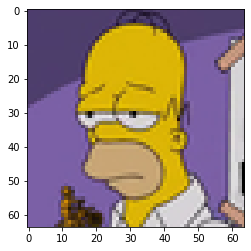

In [2]:
images = next(iter(train_loader))
images_aux = images[0]
print(images_aux.shape)
image = images_aux[10,:,:,:]
plt.imshow(image.permute(1,2,0).squeeze().numpy())
plt.show()  

In [3]:
# Convolution + BatchNormnalization + ReLU block for the encoder
class ConvBNReLU(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(ConvBNReLU, self).__init__()
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

    self.pool = None
    if(pooling):
      self.pool = nn.AvgPool2d(2,2)

  def forward(self,x):
    if(self.pool):
      out = self.pool(x)
    else:
      out = x
    out = self.relu(self.bn(self.conv(out)))   
    return out

#  BatchNormnalization + ReLU block + Convolution for the decoder
class BNReLUConv(nn.Module):
  def __init__(self,in_channels, out_channels, pooling=False):
    super(BNReLUConv, self).__init__()
    self.bn = nn.BatchNorm2d(in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size=3,
                          padding = 1)

    self.pool = None
    if(pooling):
      self.pool = nn.UpsamplingNearest2d(scale_factor=2)

  def forward(self,x):
    out = self.relu(self.bn(x))
    if(self.pool):
      out = self.pool(out)
    out = self.conv(out)
    return out

# Encoder definition with 3 COnv-BN-ReLU blocks and fully-connected layer
class Encoder(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(Encoder, self).__init__()
    self.layer1 = ConvBNReLU(3,base_channels,pooling=False)
    self.layer2 = ConvBNReLU(base_channels,base_channels*2,pooling=True)
    self.layer3 = ConvBNReLU(base_channels*2,base_channels*4,pooling=False)
    self.layer4 = ConvBNReLU(base_channels*4,base_channels*8,pooling=True)
    self.layer5 = ConvBNReLU(base_channels*8,base_channels*16,pooling=False)
    self.fc = nn.Linear(16*16*base_channels*16,out_features)
  
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    return self.fc(out.view(x.shape[0],-1))
    
# Decoder definition with a fully-connected layer and 3 BN-ReLU-COnv blocks and 
class Decoder(nn.Module):
  def __init__(self,out_features,base_channels=16):
    super(Decoder, self).__init__()
    self.base_channels = base_channels
    self.fc = nn.Linear(out_features,16*16*base_channels*16)
    self.layer5 = BNReLUConv(base_channels*16,base_channels*8,pooling=False)
    self.layer4 = BNReLUConv(base_channels*8,base_channels*4,pooling=True)
    self.layer3 = BNReLUConv(base_channels*4,base_channels*2,pooling=False)
    self.layer2 = BNReLUConv(base_channels*2,base_channels,pooling=True)
    self.layer1 = BNReLUConv(base_channels,3,pooling=False)
  
  def forward(self,x):
    out = self.fc(x)
    out = out.view(x.shape[0],self.base_channels*16,16,16)
    out = self.layer5(out)
    out = self.layer4(out)
    out = self.layer3(out)
    out = self.layer2(out)
    out = self.layer1(out)
    return torch.sigmoid(out)

In [4]:
class VAE(nn.Module):
  def __init__(self, out_features,base_channels=16):
    super(VAE, self).__init__()
    self.out_features = out_features
    self.encoder = Encoder(out_features*2,base_channels)
    self.decoder = Decoder(out_features,base_channels)

  def encode(self,x):
    aux = self.encoder(x)
    z_mean = aux[:,0:self.out_features]
    z_log_var = aux[:,self.out_features::]
    return z_mean, z_log_var

  def sample_z(self,z_mean,z_log_var):
    z_std = z_log_var.mul(0.5).exp()
    samples_unit_normal = torch.randn_like(z_mean)
    samples_z = samples_unit_normal*z_std + z_mean
    return samples_z

  def forward(self,x):
    z_mean, z_log_var = self.encode(x)
    samples_z = self.sample_z(z_mean,z_log_var)
    x_rec = self.decoder(samples_z)
    return x_rec, z_mean, z_log_var


In [5]:
## Kullback-Leibler regularization computation
def kl_divergence(z_mean,z_log_var):
  kl_loss = 0.5 * torch.sum(  (torch.exp(z_log_var) + z_mean**2 - 1.0 - z_log_var),axis=1)
  return kl_loss.mean()

# Train function
def train_VAE(vae,  train_loader, optimizer, kl_weight=0.001, num_epochs=10, model_name='vae_faces.ckpt', device='cpu'):
    vae.to(device)
    vae.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    KL_divergecnes = []
    criterion = nn.MSELoss() # Use mean-squared error to compare the original and reconstructe images
    
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        rec_loss_avg = 0
        kl_loss_avg = 0
        nBatches = 0
        for i, (imagess) in enumerate(train_loader):
            images = imagess[0]
            # Get batch of samples and labels
            images = images.to(device)

            # Forward pass (get encoder variables and reconstructed images)
            x_rec, z_mean, z_log_var = vae(images)

            reconstruction_loss = criterion(x_rec, images) # Reconstruction loss (x,x_rec)
            kl_loss = kl_divergence(z_mean, z_log_var) # Compute KL divergecnes KL( N(mu_x,sigma_x) || N(0,I))
            
            # Backward and optimize reconstruction loss and kl regularization
            optimizer.zero_grad()
            loss = reconstruction_loss + kl_loss*kl_weight # we use a weight to balance the importance of the KL loss
            loss.backward()
            optimizer.step()

            rec_loss_avg += reconstruction_loss.cpu().item()
            kl_loss_avg += kl_loss.cpu().item()

            nBatches+=1
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Rec. Loss: {:.4f}, KL Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, rec_loss_avg / nBatches, kl_loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Rec. Loss: {:.4f}, KL Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, rec_loss_avg / nBatches, kl_loss_avg / nBatches))
        
        reconstruction_error = rec_loss_avg / nBatches
        losses_list.append(reconstruction_error)
        KL_divergecnes.append(kl_loss_avg / nBatches)
        torch.save(vae.state_dict(), results_path+ '/' + model_name)
        
        if ((epoch+1) % 2 == 0 or (epoch+1) == 1):
          print ('Reconstruction Error: {}' .format(reconstruction_error))

          plt.figure(figsize=(27,9))
          plt.subplot(1,3,1)
          plt.title('Original Images')
          image_grid = make_grid(images.cpu(),nrow=10,padding=1)
          plt.imshow(image_grid.permute(1,2,0).detach().numpy())

          plt.subplot(1,3,2)
          plt.title('Reconstructed Images')
          image_grid = make_grid(x_rec.cpu(),nrow=10,padding=1)
          plt.imshow(image_grid.permute(1,2,0).detach().numpy())

          n_samples = 64
          z = torch.randn((n_samples,vae.out_features)).to(device)
          x_rec = vae.decoder(z)
          plt.subplot(1,3,3)
          plt.title('Generated Images')
          image_grid = make_grid(x_rec.cpu(),nrow=8,padding=1)
          plt.imshow(image_grid.permute(1,2,0).detach().numpy())
          plt.show()
          
    return losses_list, KL_divergecnes

Epoch [1/500], Step [16/16], Rec. Loss: 0.0703, KL Loss: 4906800493120.7158
Reconstruction Error: 0.07034247880801558


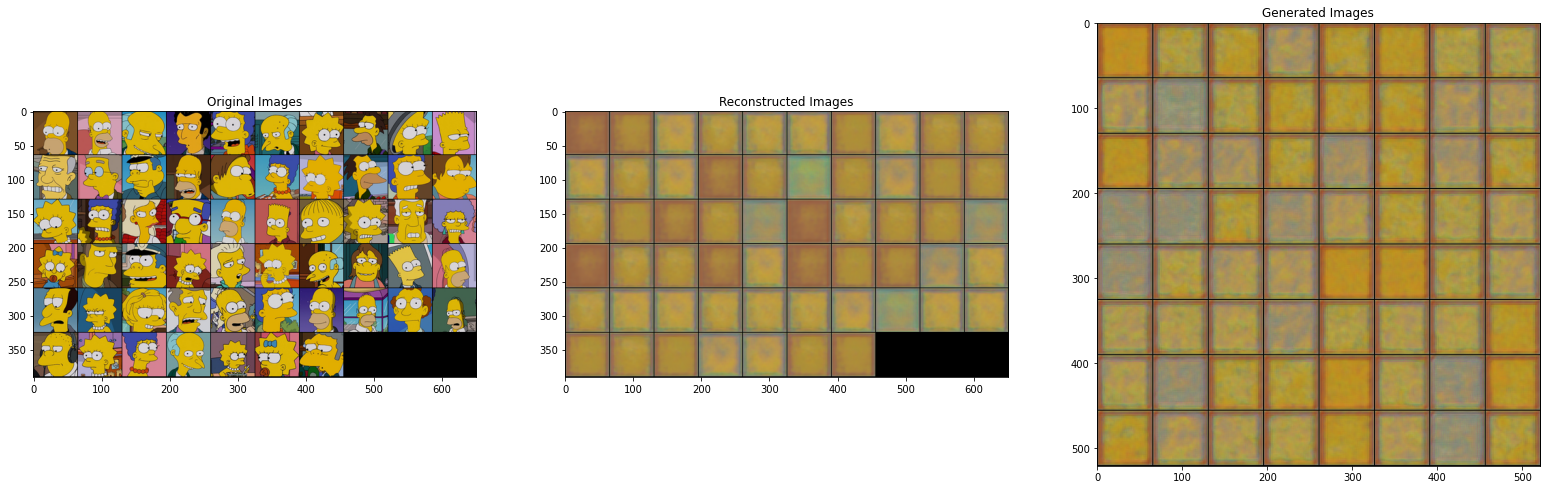

In [ ]:
# Training a VAE 
vae = VAE(64)
kl_weight=0.001 

#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.Adam(vae.parameters(),lr = learning_rate, weight_decay=1e-5)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss_list, KL_divergecnes = train_VAE(vae, train_loader, optimizer, kl_weight=kl_weight,
                      num_epochs=500, model_name='VAE.ckpt', device=device)

In [ ]:
### Load trained VAE
vae = VAE(64)
vae.eval()
vae.load_state_dict(torch.load(results_path+'/VAE.ckpt')) # Load model
vae = vae.to(device)
n_samples = 64
n_iterpolations =50
z_init = torch.randn((n_samples,vae.out_features)).to(device)*2
z_final = torch.randn((n_samples,vae.out_features)).to(device)*2
interpolation_images = []
for interp in range(0,n_iterpolations):
  interp_0_1 = float(interp) / (n_iterpolations-1)
  z = z_init*interp_0_1 + z_final*(1-interp_0_1)
  x_rec = vae.decoder(z)
  image_grid = make_grid(x_rec.cpu(),nrow=8,padding=1)
  image_grid = image_grid.permute(1,2,0).detach().numpy()
  interpolation_images.append((image_grid*255.0).astype(np.uint8))
interpolation_images += interpolation_images[::-1]
# Generate and visualize a give showing the interpolation results.
imname = results_path+'/VAE.gif'
imageio.mimsave(imname, interpolation_images, fps=25)
